VDP example with Zhang DMD

In [261]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

from odmd import OnlineDMD
import time

In [262]:
%run fDMD_functions.ipynb


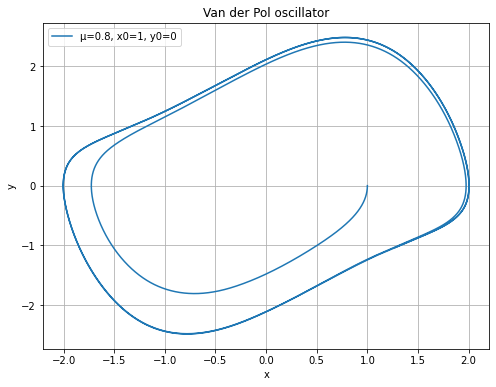

(2, 2001)


In [263]:
#Van der Pol oscillator system
initial_condition = (1,0)
mu = 0.8
t_span=(0,20)
t_eval = np.linspace(t_span[0], t_span[1], 2000001)


def van_der_pol(t, state, mu):
    x, y = state
    dxdt = y
    dydt = mu * (1 - x**2) * y - x
    return [dxdt, dydt]


sol = solve_ivp(van_der_pol, t_span, [initial_condition[0], initial_condition[1]], args=(mu,), t_eval=t_eval, vectorized=True) #u sol.y[0] i sol.y[1] su (x,y) koordinate točke za svaki trenutak

#print(sol.y[0].shape, sol.y[1].shape)
#print(sol.t.shape)

plt.figure(figsize=(8,6))
plt.plot(sol.y[0], sol.y[1], label=f"μ={mu}, x0={initial_condition[0]}, y0={initial_condition[1]}")

    
plt.title("Van der Pol oscillator")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

t_used=np.arange(0,2000001,1000)
del (t_eval)
vdp = sol.y[:,t_used]
#vremenski intervali 0.01, od trena 0 do 20
print(vdp.shape)



In [264]:
(n,m)=vdp.shape

In [265]:
#bez stackanja

q = 10 #toliko uzmem za pocetak
#evalsonlineDMD1 = np.empty((n, m), dtype=complex)
odmd = OnlineDMD(n, 1.0)
odmd.initialize(vdp[:, :q], vdp[:, 1:q+1])
start = time.time()
for k in range(q, m-1):
    odmd.update(vdp[:, k], vdp[:, k+1])
    #evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")

Lambda, Z = odmd.computemodes()
print(Lambda)
print(Z)

Online DMD, weighting = 1, time = 0.12217307090759277 secs
[1.00004999+0.010036j 1.00004999-0.010036j]
[[0.00705154-0.70580708j 0.00705154+0.70580708j]
 [0.708369  +0.j         0.708369  -0.j        ]]


In [266]:
Z_nas, Lambda_nas, r, Q, L = fGEDMDQ_multiple_trajectories(vdp[:,:q], vdp[:,1:q+1])
start_nas = time.time()
for k in range(q, m-1):
    Z_nas, Lambda_nas, r, Q, L = fDMD_added_snap(np.bmat([vdp[:,k],vdp[:,k+1]]).T, Q, L)
end_nas = time.time()
print("time: ", end_nas-start_nas, "sec")

print(Lambda_nas); print(Z)

#isti rezultati, ali nase puno sporije..

time:  1.7540910243988037 sec
[1.00004999+0.010036j 1.00004999-0.010036j]
[[0.00705154-0.70580708j 0.00705154+0.70580708j]
 [0.708369  +0.j         0.708369  -0.j        ]]


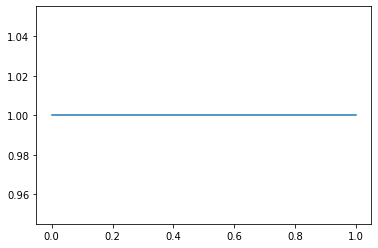

In [267]:
plt.plot(r) #provjeri je li se krivo racuna..

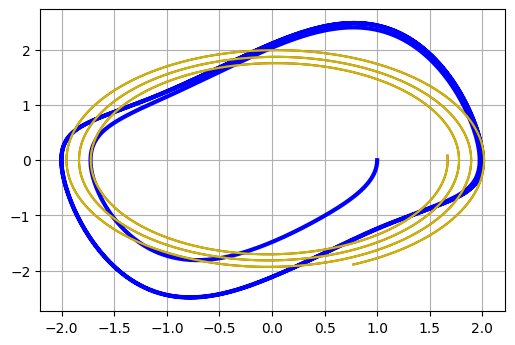

In [268]:
#kako izgleda rekonstrukcija s ovim modovima?
indices=np.array([0,1]); times=[i for i in range(m)]

reconstructed = DMD_reconstruction(vdp, Z_nas, indices, Lambda_nas, times)
reconstructed_zhang = DMD_reconstruction(vdp, Z, indices, Lambda, times)

plt.figure(dpi=100)
plt.plot(vdp[0,:], vdp[1,:], color="blue", lw=3)
plt.plot(reconstructed[0,:], reconstructed[1,:], color="red")
plt.plot(reconstructed_zhang[0,:], reconstructed_zhang[1,:], color="y")
plt.grid()

#jasno da je lose.. moramo stackat - isto za nas i za njihov

# STACKED

In [269]:
#pazi da ne runas vise od jednom..

#num_stack = 30
num_stack=60
#num_stack=70 
m=vdp.shape[1]
vdp_end=vdp[:,-num_stack:]
vdp = vdp[:,:(m-num_stack+1)]

for i in range(1,num_stack):
    added=np.concatenate((vdp[:2,i:], vdp_end[:2,:i]), axis=1)
    vdp=np.vstack((vdp,added))

(n, m)=vdp.shape

In [270]:
q = 300 #toliko uzmem za pocetak
kraj=m
odmd1 = OnlineDMD(n, 1.0)
odmd1.initialize(vdp[:, :q], vdp[:, 1:q+1]) #vec ako ovo rekonstruiram i plotam problemi.. zasto?
start = time.time()
for k in range(q, kraj-1):
    odmd1.update(vdp[:, k], vdp[:, k+1])
    #evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")

Lambda, Z = odmd1.computemodes()
print(Lambda)
print(Z)

Online DMD, weighting = 1, time = 0.9717621803283691 secs
[-0.97009466+0.10032365j -0.97009466-0.10032365j -0.96825293+0.010445j
 -0.96825293-0.010445j   -0.95384767+0.20695755j -0.95384767-0.20695755j
 -0.95024733+0.14058668j -0.95024733-0.14058668j -0.9239721 +0.30930447j
 -0.9239721 -0.30930447j -0.91723188+0.27329008j -0.91723188-0.27329008j
 -0.88485867+0.39558316j -0.88485867-0.39558316j -0.84007795+0.49308686j
 -0.84007795-0.49308686j -0.8698566 +0.41522711j -0.8698566 -0.41522711j
 -0.78263995+0.58270828j -0.78263995-0.58270828j -0.79837654+0.53350128j
 -0.79837654-0.53350128j -0.70677261+0.66799375j -0.70677261-0.66799375j
 -0.72019457+0.64585698j -0.72019457-0.64585698j -0.6422153 +0.73071565j
 -0.6422153 -0.73071565j -0.60599632+0.75232987j -0.60599632-0.75232987j
 -0.56074104+0.7963475j  -0.56074104-0.7963475j  -0.46944764+0.85393137j
 -0.46944764-0.85393137j -0.4954532 +0.82645609j -0.4954532 -0.82645609j
 -0.59467207+0.48946368j -0.59467207-0.48946368j -0.37415974+0.88985

In [271]:
Z.shape

(120, 120)

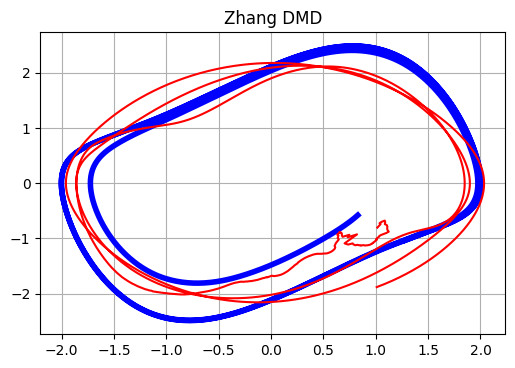

In [279]:
indices_zhang=np.array([i for i in range (Z.shape[1])]); times=[i for i in range(m+100)]
reconstructed_zhang = DMD_reconstruction(vdp[:,:kraj], Z, indices_zhang, Lambda, times)

plt.figure(dpi=100)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="b", lw=4)
plt.plot(reconstructed_zhang[-2,:kraj], reconstructed_zhang[-1,:kraj], color="r")
plt.grid()
plt.title('Zhang DMD')
plt.show()

In [280]:
q=300 #moram imati vise od 240 elemenata za sad
Z_nas, Lambda_nas, r, Q, L = fGEDMDQ_multiple_trajectories(vdp[:,:q], vdp[:,1:q+1], tol=1e-6)
start_nas = time.time()
for k in range(q, kraj-1):
    Z_nas, Lambda_nas, r, Q, L = fDMD_added_snap(np.bmat([vdp[:,k],vdp[:,k+1]]).T, Q, L, tol=1e-6)
end_nas = time.time()
print("time: ", end_nas-start_nas, "sec")

print(Lambda_nas); print(Z_nas)


time:  78.33364701271057 sec
[-0.97100544+0.j         -0.96392689+0.10409714j -0.96392689-0.10409714j
 -0.92302759+0.07829223j -0.92302759-0.07829223j -0.94855744+0.20416912j
 -0.94855744-0.20416912j -0.92179411+0.30560271j -0.92179411-0.30560271j
 -0.89930637+0.23464396j -0.89930637-0.23464396j -0.88134386+0.40121039j
 -0.88134386-0.40121039j -0.8554986 +0.38280039j -0.8554986 -0.38280039j
 -0.8370108 +0.491876j   -0.8370108 -0.491876j   -0.7794763 +0.58039574j
 -0.7794763 -0.58039574j -0.78636718+0.51975537j -0.78636718-0.51975537j
 -0.70725622+0.65981251j -0.70725622-0.65981251j -0.70760834+0.64103518j
 -0.70760834-0.64103518j -0.64146086+0.72896016j -0.64146086-0.72896016j
 -0.59991118+0.74822979j -0.59991118-0.74822979j -0.55954416+0.79618327j
 -0.55954416-0.79618327j -0.49061618+0.82873058j -0.49061618-0.82873058j
 -0.46821581+0.85432644j -0.46821581-0.85432644j -0.38481885+0.888608j
 -0.38481885-0.888608j   -0.35975515+0.90188354j -0.35975515-0.90188354j
 -0.28442881+0.92934253j

In [281]:
Z_nas.shape #104x106 - zasto..

(120, 114)

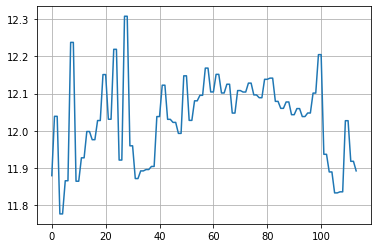

In [282]:
plt.plot(r) #opet vece nego sto smo navikli s overparametrized modelima (ocekivano!)
plt.grid()

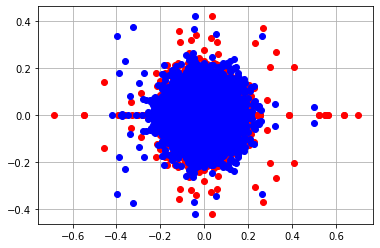

In [283]:
plt.plot(np.real(Z), np.imag(Z), 'o', color="r")
plt.plot(np.real(Z_nas), np.imag(Z_nas), 'o', color="b")
plt.grid()
plt.show()

(114,)
(50,)


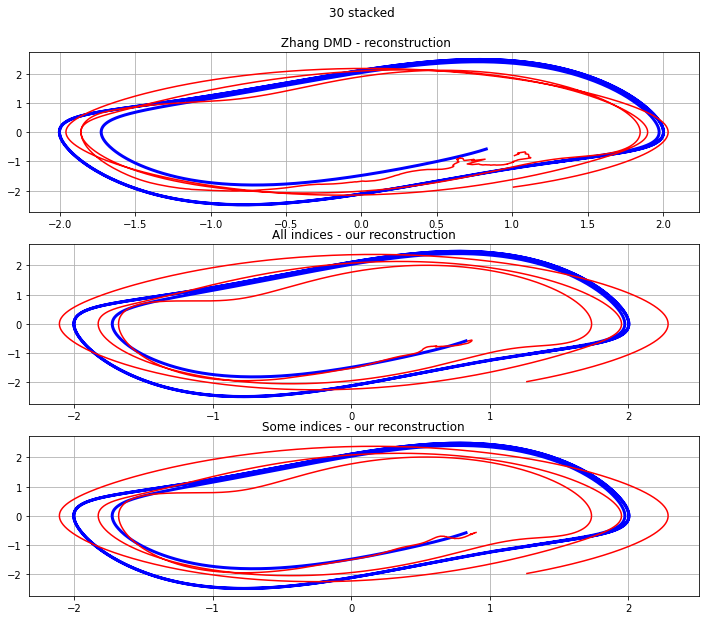

In [284]:
indices_nas=np.array([i for i in range (Z_nas.shape[1])]); times=[i for i in range(m+100)]
#indices_nas = np.where(r<np.mean(r))[0] #ako s ovime imam 35 indeksa umjesto 59 i slicni rezultat..
print(indices_nas.shape)
reconstructed_nas = DMD_reconstruction(vdp[:,:kraj], Z_nas, indices_nas, Lambda_nas, times)

plt.figure(figsize=(12, 10))

plt.subplot(3,1,1)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_zhang[-2,:kraj], reconstructed_zhang[-1,:kraj], color="red")
plt.grid()
plt.title("30 stacked \n\n Zhang DMD - reconstruction")

plt.subplot(3,1,2)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_nas[-2,:kraj], reconstructed_nas[-1,:kraj], color="red")
plt.grid()
plt.title("All indices - our reconstruction")


indices_nas = np.where(r<np.mean(r))[0] #ako s ovime imam 35 indeksa umjesto 59 i slicni rezultat..
print(indices_nas.shape)
reconstructed_nas_dio = DMD_reconstruction(vdp[:,:kraj], Z_nas, indices_nas, Lambda_nas, times)

plt.subplot(3,1,3)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_nas_dio[-2,:kraj], reconstructed_nas_dio[-1,:kraj], color="red")
plt.grid()
plt.title("Some indices - our reconstruction")

plt.show()
